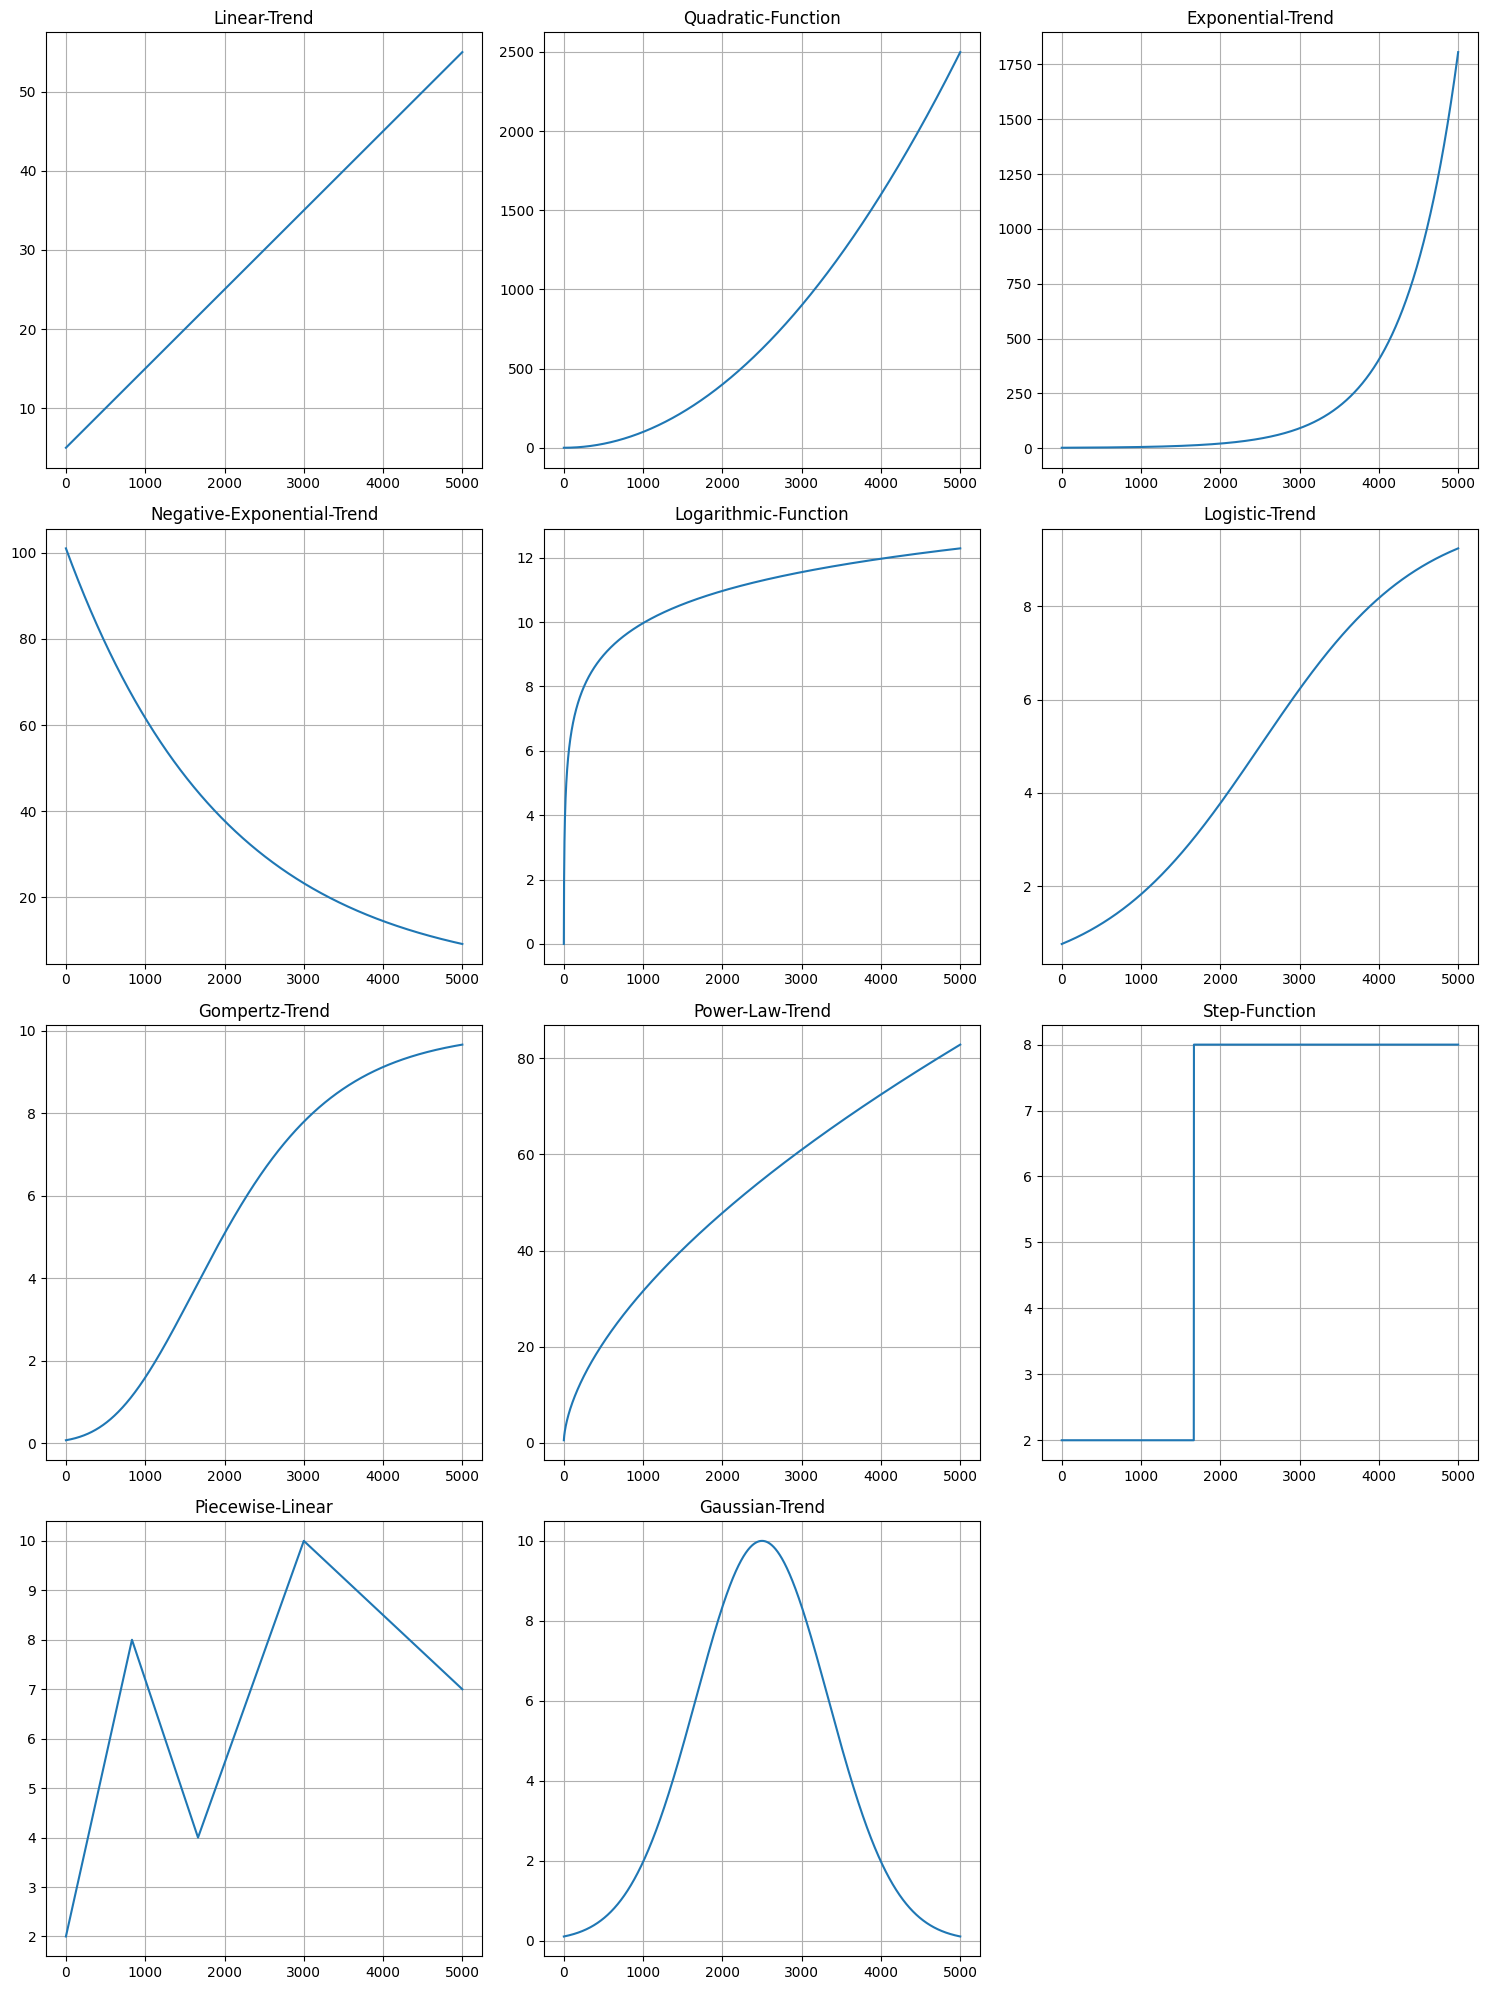

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from statsmodels.tsa.arima_process import ArmaProcess
import pandas as pd

# Functions for generating different types of signals
def generate_linear_signal(n, slope=10, intercept=0):
    """Generate a linear trend signal"""
    x = np.arange(n)
    return slope * x + intercept

def generate_quadratic_signal(n, a=1, b=1, c=1):
    """Generate a quadratic signal"""
    x = np.arange(n)
    return a * x ** 2 + b * x + c

def generate_exponential_signal(n, rate=0.01, a=1):
    """Generate an exponential trend signal"""
    x = np.arange(n)
    return a * np.exp(rate * x) + 1

def generate_logarithmic_signal(n, base=2):
    """Generate a logarithmic signal"""
    x = np.arange(1, n + 1)
    return np.log(x) / np.log(base)

def generate_logistic_signal(n, L=1, k=0.1, t0=None):
    """
    Generate a logistic (sigmoid) function signal representing S-shaped growth.
    
    Parameters:
    n (int): Length of the signal
    L (float): The curve's maximum value
    k (float): The growth rate or steepness of the curve
    t0 (float): The time of the sigmoid's midpoint (defaults to n/2)
    """
    if t0 is None:
        t0 = n / 2
        
    x = np.arange(n)
    return L / (1 + np.exp(-k * (x - t0)))

def generate_gompertz_signal(n, a=1, b=2, k=0.1):
    """
    Generate a Gompertz function signal, used in biology and economics.
    
    Parameters:
    n (int): Length of the signal
    a (float): The asymptotic value
    b (float): Displacement along the x-axis
    k (float): Growth rate
    """
    x = np.arange(n)
    return a * np.exp(-b * np.exp(-k * x))

def generate_power_law_signal(n, a=1, b=0.5):
    """
    Generate a power law signal for scaling relationships.
    
    Parameters:
    n (int): Length of the signal
    a (float): Scale parameter
    b (float): Power exponent
    """
    x = np.arange(1, n + 1)  # Avoid x=0 if b<0
    return a * x**b

def generate_step_signal(n, t0=None, c=0, d=1):
    """
    Generate a step function signal representing a sudden change.
    
    Parameters:
    n (int): Length of the signal
    t0 (int): Step transition point (defaults to n/2)
    c (float): Value before step
    d (float): Value after step
    """
    if t0 is None:
        t0 = n // 2
        
    signal = np.ones(n) * c
    signal[t0:] = d
    return signal

def generate_piecewise_linear_signal(n, breakpoints, values):
    """
    Generate a piecewise linear signal with specified values at breakpoints.
    
    Parameters:
    n (int): Length of the signal
    breakpoints (list): List of x-indices where values are specified
    values (list): List of y-values at the breakpoints
    """
    assert len(breakpoints) == len(values), "Number of breakpoints must equal number of values"
    
    # Add endpoints if not present
    if 0 not in breakpoints:
        breakpoints = [0] + list(breakpoints)
        values = [values[0]] + list(values)
    if n-1 not in breakpoints:
        breakpoints = list(breakpoints) + [n-1]
        values = list(values) + [values[-1]]
    
    # Sort by breakpoints
    bp_values = sorted(zip(breakpoints, values))
    sorted_bp = [bp for bp, _ in bp_values]
    sorted_values = [val for _, val in bp_values]
    
    # Create signal using linear interpolation
    signal = np.zeros(n)
    for i in range(len(sorted_bp) - 1):
        start_idx = sorted_bp[i]
        end_idx = sorted_bp[i + 1]
        start_val = sorted_values[i]
        end_val = sorted_values[i + 1]
        
        # Linear interpolation
        if end_idx > start_idx:
            segment = np.linspace(start_val, end_val, end_idx - start_idx + 1)
            signal[start_idx:end_idx + 1] = segment
    
    return signal

def generate_gaussian_signal(n, a=1, t0=None, sigma=None):
    """
    Generate a Gaussian (bell curve) signal.
    
    Parameters:
    n (int): Length of the signal
    a (float): Peak amplitude
    t0 (float): Center position (defaults to n/2)
    sigma (float): Standard deviation (defaults to n/10)
    """
    if t0 is None:
        t0 = n / 2
    if sigma is None:
        sigma = n / 10
        
    x = np.arange(n)
    return a * np.exp(-((x - t0)**2) / (2 * sigma**2))

# Periodic signal generation functions
def generate_sine_wave(n, amplitude=1, frequency=0.5, phase=0):
    """Generate a sine wave signal"""
    x = np.arange(n)
    return amplitude * np.sin(2 * np.pi * frequency * x + phase)

def generate_composite_sine(n, components):
    """
    Generate a signal composed of multiple sine waves.
    
    Parameters:
    n (int): Length of the signal
    components (list): List of tuples, each containing (amplitude, frequency, phase_shift, wave_type)
                      where wave_type is 'sin' or 'cos' (defaults to 'sin' if not specified)
    
    Returns:
    numpy.ndarray: The composite signal
    """
    x = np.arange(n)
    signal = np.zeros(n)
    
    for component in components:
        if len(component) == 3:
            amplitude, frequency, phase_shift = component
            wave_type = 'sin'
        elif len(component) == 4:
            amplitude, frequency, phase_shift, wave_type = component
        else:
            raise ValueError("Each component must be a tuple of (amplitude, frequency, phase_shift) or (amplitude, frequency, phase_shift, wave_type)")
        
        if wave_type.lower() == 'sin':
            signal += amplitude * np.sin(2 * np.pi * frequency * x + phase_shift)
        elif wave_type.lower() == 'cos':
            signal += amplitude * np.cos(2 * np.pi * frequency * x + phase_shift)
        else:
            raise ValueError("wave_type must be 'sin' or 'cos'")
            
    return signal

def generate_cosine_wave(n, amplitude=1, frequency=0.5, phase=0):
    """Generate a cosine wave signal"""
    x = np.arange(n)
    return amplitude * np.cos(2 * np.pi * frequency * x + phase)

def generate_triangle_wave(n, amplitude=1, frequency=0.5):
    """Generate a triangle wave signal"""
    return amplitude * signal.sawtooth(2 * np.pi * frequency * np.arange(n), 0.5)

def generate_sawtooth_wave(n, amplitude=1, frequency=0.5):
    """Generate a sawtooth wave signal"""
    return amplitude * signal.sawtooth(2 * np.pi * frequency * np.arange(n))

def generate_square_wave(n, amplitude=1, frequency=0.5):
    """Generate a square wave signal"""
    return amplitude * signal.square(2 * np.pi * frequency * np.arange(n))

# Stochastic process functions
def generate_autoregressive_signal(n, coeffs=[0.6, 0.2, 0.15], noise_std=1):
    """Generate an autoregressive (AR) signal"""
    ar_signal = np.zeros(n)
    for i in range(len(coeffs), n):
        ar_signal[i] = sum(coeff * ar_signal[i - j - 1] for j, coeff in enumerate(coeffs))
        ar_signal[i] += np.random.normal(0, noise_std)
    return ar_signal

def generate_arma_signal(n, ar_params, ma_params):
    """Generate an ARMA (AutoRegressive Moving Average) signal"""
    arma_process = ArmaProcess(ar=np.r_[1, -np.array(ar_params)], ma=np.r_[1, np.array(ma_params)])
    return arma_process.generate_sample(nsample=n)

def generate_random_walk(n, start=0):
    """Generate a random walk signal"""
    steps = np.random.normal(0, 1, n)
    return np.cumsum(steps) + start

def generate_white_noise(n, mean=0, std=1):
    """Generate white noise"""
    return np.random.normal(mean, std, n)

def generate_garch_signal(n=1000, omega=0.1, alpha=0.2, beta=0.7, seed=None):
    """
    Generate GARCH(1,1) time series data
    
    Parameters:
        n: sequence length
        omega: constant term (must be > 0)
        alpha: ARCH coefficient (must be >= 0)
        beta: GARCH coefficient (must be >= 0)
        seed: random seed
        
    Returns:
        returns: generated time series
        sigma2: conditional variance series
    """
    assert alpha + beta < 1, "α+β must be less than 1 to ensure stationarity"
    assert omega > 0, "ω must be greater than 0"
    
    np.random.seed(seed)
    returns = np.zeros(n)
    sigma2 = np.zeros(n)
    
    # Initialize conditional variance
    sigma2[0] = omega / (1 - alpha - beta)
    
    # Generate GARCH process
    for t in range(1, n):
        returns[t] = np.random.normal(0, np.sqrt(sigma2[t-1]))
        sigma2[t] = omega + alpha * returns[t-1]**2 + beta * sigma2[t-1]
    
    return returns, sigma2

# Noise and anomaly functions
def add_noise_by_snr(signal, snr_db=20):
    """Add Gaussian noise based on signal-to-noise ratio (SNR in dB)"""
    signal_power = np.var(signal)  # Signal power (variance)
    snr_linear = 10 ** (snr_db / 10)  # Convert dB to linear scale
    noise_variance = signal_power / snr_linear  # Noise variance = signal power / SNR
    noise = np.random.normal(0, np.sqrt(noise_variance), len(signal))
    return signal + noise

def add_poisson_noise(signal):
    """Add Poisson noise (signal must be non-negative)"""
    # Shift signal to non-negative if it contains negative values
    offset = np.min(signal)
    if offset < 0:
        signal_shifted = signal - offset
    else:
        signal_shifted = signal
    
    # Poisson noise variance equals mean, so SNR calculation not needed
    noisy_signal = np.random.poisson(np.maximum(signal_shifted, 0))  # Ensure non-negative
    
    # Restore original signal offset
    if offset < 0:
        noisy_signal = noisy_signal + offset
    return noisy_signal

def add_point_anomalies(signal, anomaly_ratio=0.05, base_amplitude_range=(0.1, 0.3)):
    """
    Add point anomalies, with anomaly amplitudes adaptively adjusted based on signal range
    
    Parameters:
    signal: input signal
    anomaly_ratio: proportion of anomalous points
    base_amplitude_range: base range for anomaly amplitudes (will be adjusted based on signal range)
    """
    signal_range = np.max(signal) - np.min(signal)
    signal_length = len(signal)
    train_length = int(signal_length * 0.8)  # Only add anomalies in first 80% of data
    num_anomalies = int(train_length * anomaly_ratio)
    
    # Adjust anomaly amplitude based on signal range
    if signal_range > 100:
        adjusted_amplitude_range = (base_amplitude_range[0] * 0.2, base_amplitude_range[1] * 0.2)
    elif signal_range < 4:
        adjusted_amplitude_range = (base_amplitude_range[0] * 2, base_amplitude_range[1] * 2)
    else:
        adjusted_amplitude_range = base_amplitude_range
    
    # Print debug info
    print(f"Signal range: {signal_range}")
    print(f"Adjusted anomaly amplitude range: {adjusted_amplitude_range[0] * signal_range} to {adjusted_amplitude_range[1] * signal_range}")
    
    # Randomly select anomaly positions (only in first 80% of data)
    anomaly_positions = np.random.choice(train_length, num_anomalies, replace=False)
    
    # Generate anomalous signal
    anomalous_signal = signal.copy()
    for pos in anomaly_positions:
        sign = np.random.choice([-1, 1])
        amplitude = np.random.uniform(adjusted_amplitude_range[0], adjusted_amplitude_range[1]) * signal_range
        anomalous_signal[pos] += sign * amplitude
    
    return anomalous_signal

def add_pulse_anomalies(signal, num_pulses=3, pulse_width_range=(10, 30), base_amplitude_range=(0.1, 0.3)):
    """
    Add pulse anomalies, with anomaly amplitudes adaptively adjusted based on signal range
    
    Parameters:
    signal: input signal
    num_pulses: number of pulse anomalies
    pulse_width_range: range of pulse widths (in sample points)
    base_amplitude_range: base range for anomaly amplitudes (will be adjusted based on signal range)
    """
    signal_range = np.max(signal) - np.min(signal)
    signal_length = len(signal)
    train_length = int(signal_length * 0.8)  # Only add anomalies in first 80% of data
    
    # Adjust anomaly amplitude based on signal range
    if signal_range > 100:
        adjusted_amplitude_range = (base_amplitude_range[0] * 0.8, base_amplitude_range[1] * 0.8)
    elif signal_range < 4:
        adjusted_amplitude_range = (base_amplitude_range[0] * 2, base_amplitude_range[1] * 2)
    else:
        adjusted_amplitude_range = base_amplitude_range
    
    # Print debug info
    print(f"Signal range: {signal_range}")
    print(f"Adjusted pulse amplitude range: {adjusted_amplitude_range[0] * signal_range} to {adjusted_amplitude_range[1] * signal_range}")
    
    anomalous_signal = signal.copy()
    
    # Ensure sufficient spacing between pulses, but only in first 80% of data
    min_distance = max(pulse_width_range[1], train_length // (num_pulses * 2))
    
    # Generate non-overlapping pulse positions
    possible_positions = list(range(0, train_length - pulse_width_range[1]))
    pulse_positions = []
    for _ in range(num_pulses):
        while possible_positions:
            pos = np.random.choice(possible_positions)
            if not any(abs(pos - p) < min_distance for p in pulse_positions):
                pulse_positions.append(pos)
                possible_positions = [p for p in possible_positions 
                                   if abs(p - pos) >= min_distance]
                break
    
    # Add pulses
    for pos in pulse_positions:
        width = np.random.randint(pulse_width_range[0], pulse_width_range[1])
        sign = np.random.choice([-1, 1])
        amplitude = np.random.uniform(adjusted_amplitude_range[0], adjusted_amplitude_range[1]) * signal_range
        anomalous_signal[pos:pos+width] += sign * amplitude
    
    return anomalous_signal

# Utility functions for saving and visualizing signals
def save_signal(signal, folder, signal_name, dataset_id=None, category=None, length=None):
    """
    Save signal to CSV file using a flat folder structure
    First column is timestamp, second column is signal value
    
    Parameters:
    signal: signal data
    folder: base folder
    signal_name: signal name
    dataset_id: dataset ID
    category: category (e.g., raw, SNR20dB, etc.)
    length: signal length
    """
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    # Build new filename format
    filename = signal_name
    if dataset_id is not None:
        filename = f"dataset{dataset_id}_{filename}"
    if category is not None:
        filename = f"{filename}_{category}"
    if length is not None:
        filename = f"{filename}_length{length}"
    
    # Create timestamp column (simple sequence number)
    timestamps = np.arange(len(signal))
    
    # Save data as CSV file
    df = pd.DataFrame({
        'date': timestamps,
        'Feature1': signal
    })
    
    df.to_csv(os.path.join(folder, f"{filename}.csv"), index=False)

def plot_signals(signal_data_dict):
    """Visualize multiple signals"""
    plt.figure(figsize=(15, 20))
    for i, (name, signal) in enumerate(signal_data_dict.items()):
        plt.subplot(len(signal_data_dict) // 3 + 1, 3, i + 1)
        plt.plot(signal)
        plt.title(name)
        plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main functions
def generate_and_save_datasets(seed, dataset_folder, dataset_id):
    """Generate and save a dataset with different trend signals"""
    n = 5000  # Signal length
    np.random.seed(seed)  # Set random seed
    
    # Dictionary of signal generators
    signal_generators = {
        "Linear-Trend": lambda: generate_linear_signal(n, slope=0.01, intercept=5),
        "Quadratic-Function": lambda: generate_quadratic_signal(n, a=0.0001, b=0, c=0),
        "Exponential-Trend": lambda: generate_exponential_signal(n, rate=0.0015),
        "Negative-Exponential-Trend": lambda: generate_exponential_signal(n, rate=-0.0005, a=100),
        "Logarithmic-Function": lambda: generate_logarithmic_signal(n, base=2),
        "Logistic-Trend": lambda: generate_logistic_signal(n, L=10, k=0.001),
        "Gompertz-Trend": lambda: generate_gompertz_signal(n, a=10, b=5, k=0.001),
        "Power-Law-Trend": lambda: generate_power_law_signal(n, a=0.5, b=0.6),
        "Step-Function": lambda: generate_step_signal(n, t0=n//3, c=2, d=8),
        "Piecewise-Linear": lambda: generate_piecewise_linear_signal(
            n, 
            breakpoints=[0, n//6, n//3, 3*n//5, n-1], 
            values=[2, 8, 4, 10, 7]
        ),
        "Gaussian-Trend": lambda: generate_gaussian_signal(n, a=10, sigma=n/6),
    }
    
    # 1. Generate and save raw dataset
    signal_data_dict = {}
    for signal_name, generator in signal_generators.items():
        signal_data = generator()
        signal_data_dict[signal_name] = signal_data
        save_signal(signal_data, dataset_folder, signal_name, dataset_id=dataset_id, category="raw", length=n)
    
    # Visualize raw signals
    plot_signals(signal_data_dict)

def generate_multiple_datasets(num_datasets=5):
    """Generate multiple datasets with different random seeds"""
    output_folder = "Dataset_generated_trend"  
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for i in range(num_datasets):
        seed = i
        generate_and_save_datasets(seed, output_folder, i+1)

if __name__ == "__main__":
    generate_multiple_datasets(num_datasets=1)